In [154]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time
from IPython.display import display, clear_output
import threading
import DobotDllType as dType
import math
from sklearn.cluster import KMeans

In [155]:
# Open a connection to the default camera (usually the first camera device found)
cap = cv2.VideoCapture(1)

if not cap.isOpened():
    print("Error: Could not open camera.")

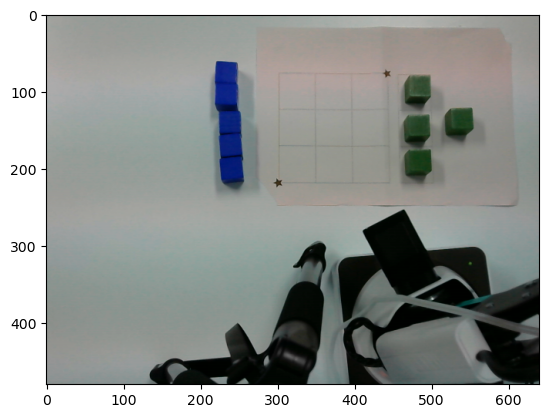

In [174]:
ret, frame = cap.read()
main_image = cv2.cvtColor(frame, cv2.IMREAD_GRAYSCALE)
plt.imshow(main_image)

## Template Matching

In [175]:
# Callback function to capture mouse events
def click_event(event, x, y, flags, param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(f'Clicked at: x={x}, y={y}')
        # Optionally, display the clicked point on the image
        # font = cv2.FONT_HERSHEY_SIMPLEX
        # cv2.putText(main_image, f'{x},{y}', (x, y), font, 1, (255, 0, 0), 2, cv2.LINE_AA)
        # display_image(main_image)
        
# Function to display image using IPython display
def display_image(img):
    clear_output(wait=True)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

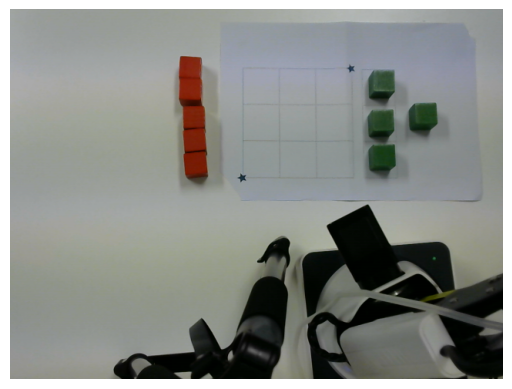

Clicked at: x=295, y=215


In [176]:
# Display the image
display_image(main_image)

# Set the mouse callback function to capture click events
cv2.namedWindow('image')
cv2.setMouseCallback('image', click_event)

# Use a loop to keep the window open for capturing events
while True:
    cv2.imshow('image', main_image)
    if cv2.waitKey(20) & 0xFF == 27:  # Exit on pressing 'ESC'
        break

cv2.destroyAllWindows()

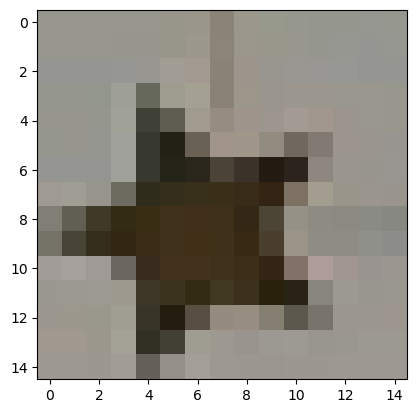

In [178]:
# Find the template from tbe image
template_pix_x = 210
template_pix_y = 295
template_size = 15

template = main_image[template_pix_x:template_pix_x+template_size, template_pix_y:template_pix_y+template_size]
plt.imshow(template)

In [179]:
# Perform template matching using cv2.matchTemplate
result = cv2.matchTemplate(main_image, template, cv2.TM_CCOEFF_NORMED)

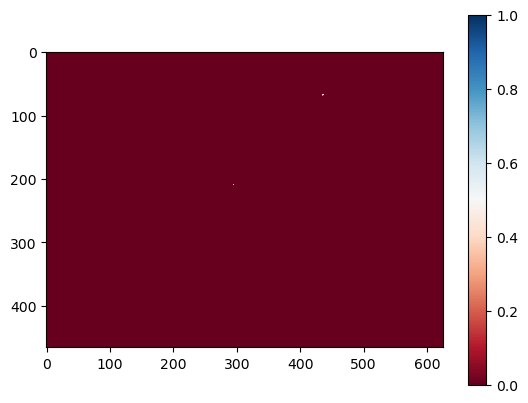

In [180]:
thresh = 0.8
result_filter = result >= thresh
plt.imshow(result_filter, cmap='RdBu')
plt.colorbar()

In [181]:
x, y = result_filter.shape
print(x,y)
pts = []
for i in range(x):
    for j in range(y):
        if result_filter[i,j] == 1:
            pts.append((j,i))

466 626


In [182]:
pts

[(436, 68), (437, 68), (436, 69), (295, 210)]

In [183]:
data = np.array(pts)

# Create a KMeans object with 2 clusters
kmeans = KMeans(n_clusters=2, random_state=42)

# Fit the KMeans algorithm to the data
kmeans.fit(data)

# Get the coordinates of the centroids
centroids = kmeans.cluster_centers_

# Round the centroid coordinates to the nearest integer
centroids_rounded = np.rint(centroids).astype(int)
refImage = centroids_rounded[np.argsort(centroids_rounded[:, 0])]
print("Centroid coordinates (rounded to the nearest integer):")
print(refImage)

Centroid coordinates (rounded to the nearest integer):
[[295 210]
 [436  68]]


C:\Users\21361535\AppData\Local\anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\21361535\AppData\Local\anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [184]:
pos_cord = {}
def gen_cord(pt1, pt2):
    x1, y1 = pt1[0], pt1[1]
    x2, y2 = pt2[0], pt2[1]

    middle_x, middle_y = (x1 + x2) / 2, (y1 + y2) / 2

    size = abs(x1 - x2) / 3

    pos_cord[1] = ( middle_x - size, middle_y - size )
    pos_cord[2] = ( middle_x,        middle_y - size )
    pos_cord[3] = ( middle_x + size, middle_y - size )
    pos_cord[4] = ( middle_x - size, middle_y )
    pos_cord[5] = ( middle_x,        middle_y )
    pos_cord[6] = ( middle_x + size, middle_y )
    pos_cord[7] = ( middle_x - size, middle_y + size )
    pos_cord[8] = ( middle_x,        middle_y + size)
    pos_cord[9] = ( middle_x + size, middle_y + size)

def draw_circle(img, x, y):
    img_cpy = img.copy()
    cv2.circle(img_cpy, (int(x), int(y)), 5, (0, 255, 0), -1)
    return img_cpy

In [185]:
pt1, pt2 = refImage[0] + int(template_size/2), refImage[1] + int(template_size/2)

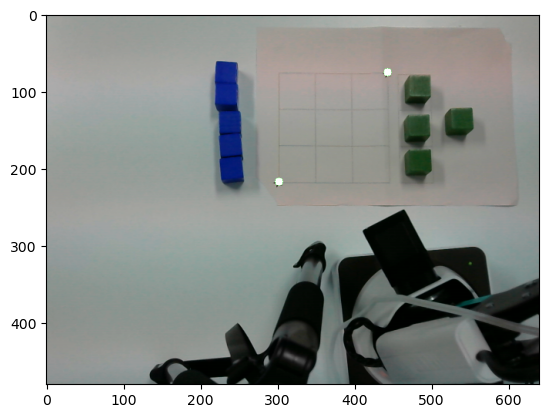

In [186]:
img_with_circles = main_image.copy()

img = draw_circle(img_with_circles, pt1[0], pt1[1])
img = draw_circle(img, pt2[0], pt2[1])

# for p in pts:
#     img[p[0],p[1]] = np.array([255,255,255,255])
plt.imshow(img)

In [187]:
gen_cord(pt1, pt2)

1


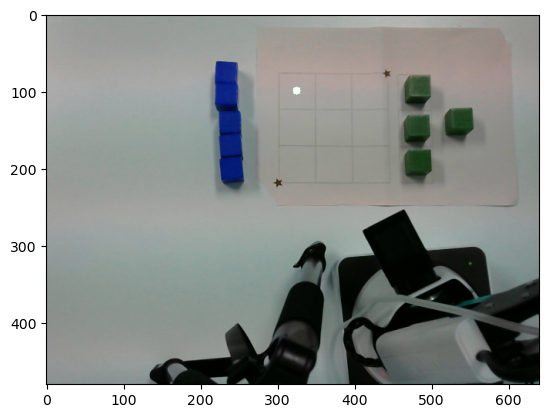

2


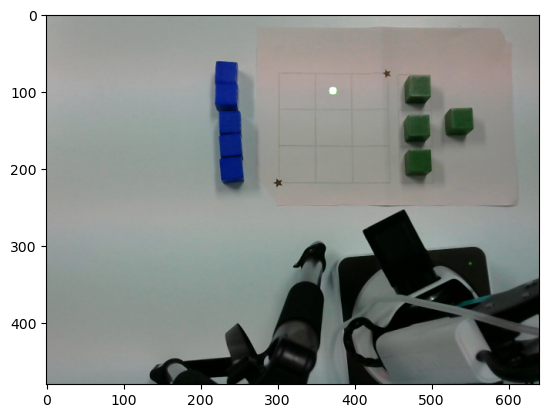

3


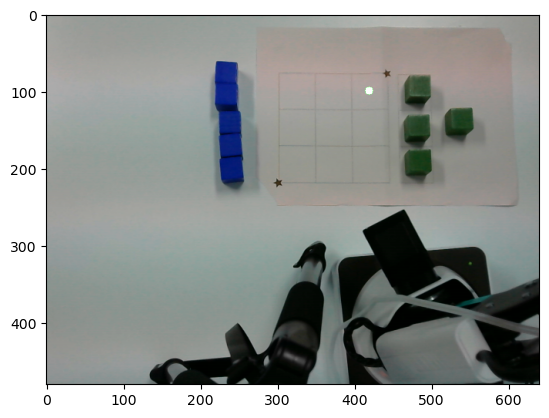

4


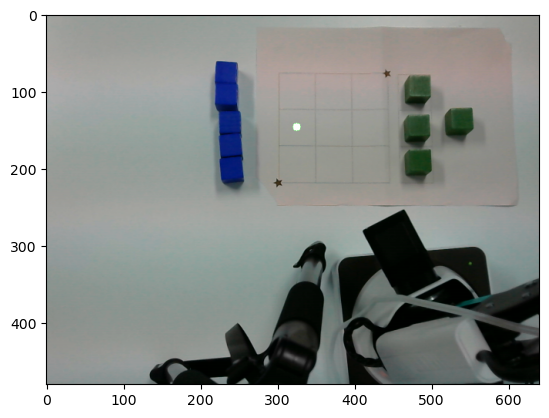

5


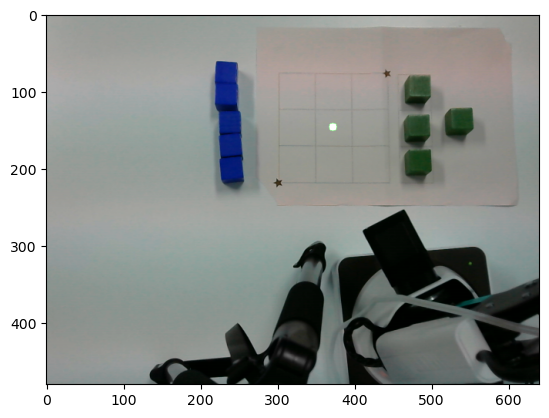

6


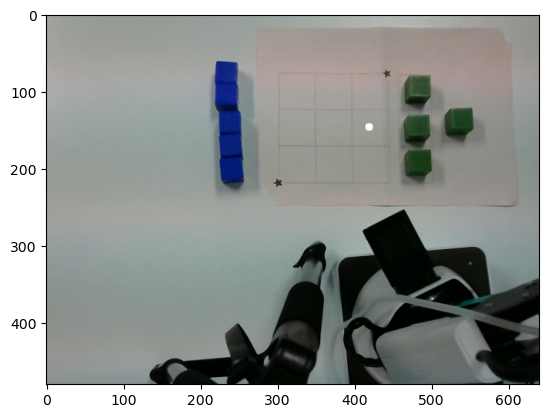

7


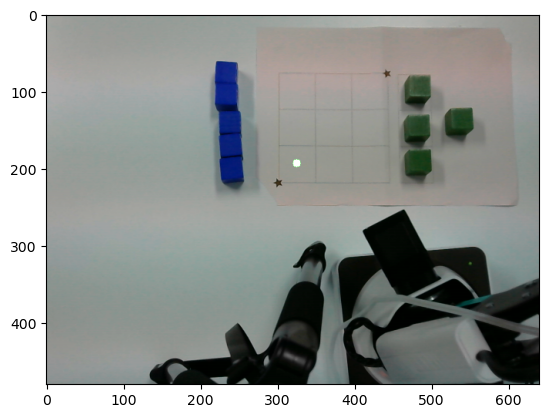

8


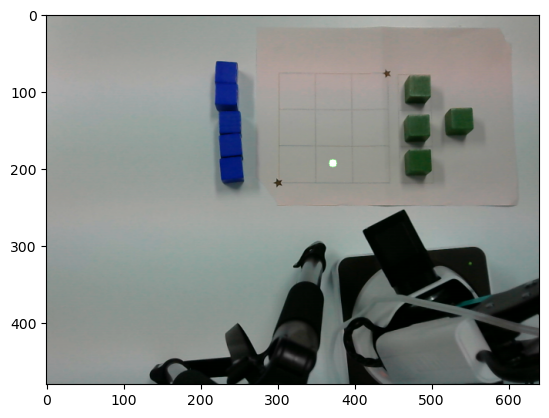

9


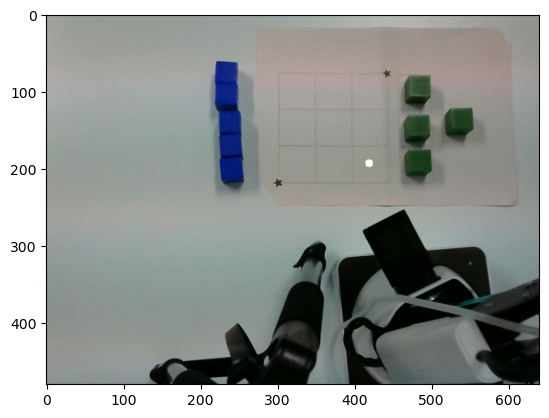

In [188]:

for idx in range(1,10):
    print(idx)
    img = draw_circle(img_with_circles, pos_cord[idx][0], pos_cord[idx][1])
    plt.imshow(img, cmap='gray')
    plt.show()

In [193]:
CON_STR = {
    dType.DobotConnect.DobotConnect_NoError:  "DobotConnect_NoError",
    dType.DobotConnect.DobotConnect_NotFound: "DobotConnect_NotFound",
    dType.DobotConnect.DobotConnect_Occupied: "DobotConnect_Occupied"}

In [194]:
#Load Dll and get the CDLL object
api = dType.load()
#建立与dobot的连接
#Connect Dobot
state = dType.ConnectDobot(api, "", 115200)[0]
print("Connect status:",CON_STR[state])

if (CON_STR[state] == "DobotConnect_NoError"):
    dType.SetQueuedCmdClear(api)
else:
    assert False

您用的dll是64位，为了顺利运行，请保证您的python环境也是64位
python环境是： ('64bit', 'WindowsPE')
Connect status: DobotConnect_Occupied


AssertionError: 

In [195]:
pickupLoc = {}
refLoc = {}
homeLoc = None
globZ = None

rob_cord = {}

In [139]:
locList = ["Z", "Pickup Loc 1", "Pickup Loc 2", "Pickup Loc 3", "Pickup Loc 4", "Home", "Ref 1", "Ref 2"]

last_print = None
def print_once(str):
    global last_print
    if last_print == str:
        return
    print(str)
    last_print = str
    
def setCoordinates(locList = locList):
    global pickupLoc, refLoc, homeLoc, globZ
    prev_pose = dType.GetPose(api)
    allLoc = []
    cnt = 0
    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        print_once(f"Set : {locList[cnt]}")
        if prev_pose == pose:
            continue
        prev_pose = pose
        allLoc.append(pose)
        print(f"Location set: {locList[cnt]}")
        cnt += 1
        if len(allLoc) == len(locList):
            break


    globZ = allLoc[0][2]
    pickupLoc[1] = (allLoc[1][0], allLoc[1][1], globZ) 
    pickupLoc[2] = (allLoc[2][0], allLoc[2][1], globZ) 
    pickupLoc[3] = (allLoc[3][0], allLoc[3][1], globZ)
    pickupLoc[4] = (allLoc[4][0], allLoc[4][1], globZ)
    
    homeLoc = (allLoc[5][0], allLoc[5][1], allLoc[5][2]) 
    refLoc[1] = (allLoc[6][0], allLoc[6][1]) 
    refLoc[2] = (allLoc[7][0], allLoc[7][1])

def setCoordinatesHome():
    global homeLoc
    prev_pose = dType.GetPose(api)
    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        homeLoc = (pose[0], pose[1], pose[2])
        print(f"Location set: Home")
        break

def setCoordinatesZ():
    global globZ
    prev_pose = dType.GetPose(api)
    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        globZ = pose[2]
        print(f"Location set: Z")
        break

def setCoordinatesRef():
    global refLoc
    if globZ == None:
        print("Set Z first")
        return 
        
    prev_pose = dType.GetPose(api)
    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        refLoc[1] = (pose[0], pose[1], globZ)
        print(f"Location set: Ref 1")
        break

    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        refLoc[2] = (pose[0], pose[1], globZ)
        print(f"Location set: Ref 2")
        break

def setCoordinatesPickup():
    global pickupLoc
    if globZ == None:
        print("Set Z first")
        return 
        
    prev_pose = dType.GetPose(api)
    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        pickupLoc[1] = (pose[0], pose[1], globZ)
        print(f"Location set: pickupLoc 1")
        break

    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        pickupLoc[2] = (pose[0], pose[1], globZ)
        print(f"Location set: pickupLoc 2")
        break

    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        pickupLoc[3] = (pose[0], pose[1], globZ)
        print(f"Location set: pickupLoc 3")
        break

    while(True):
        time.sleep(0.5)
        pose = dType.GetPose(api)
        if prev_pose == pose:
            continue
        prev_pose = pose
        pickupLoc[4] = (pose[0], pose[1], globZ)
        print(f"Location set: pickupLoc 4")
        break
        
def pick(location):
    x = location[0]
    y = location[1]

    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, x,  y,  globZ+30, current_pose[3], 1)
    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, x,  y,  globZ-5, current_pose[3], 1)
    dType.SetEndEffectorSuctionCupEx(api, 1, 1)
    dType.dSleep(1000)
    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, homeLoc[0],  homeLoc[1],  homeLoc[2], current_pose[3], 1)

def drop(location):
    x = location[0]
    y = location[1]

    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, x,  y,  globZ+30, current_pose[3], 1)
    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, x,  y,  globZ+5, current_pose[3], 1)
    dType.SetEndEffectorSuctionCupEx(api, 0, 1)
    dType.dSleep(1000)
    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, homeLoc[0],  homeLoc[1],  homeLoc[2], current_pose[3], 1)

def playPiece(iteration, location):
    pickupLocation = pickupLoc[iteration]
    pick(pickupLocation)

    finalPosition = rob_cord[location]
    drop(finalPosition)

def goto(location):
    x = location[0]
    y = location[1]

    current_pose = dType.GetPose(api)
    dType.SetPTPCmdEx(api, 2, x,  y,  globZ+30, current_pose[3], 1)

In [140]:
def get_transformation_matrix(r1, r2, i1, i2):
    x_r1 = r1[0]
    y_r1 = r1[1]

'''
Based on the robot coordinate system
'''
def setCoordinatesOfCells():

    x1, y1 = refLoc[1][0], refLoc[1][1]
    x2, y2 = refLoc[2][0], refLoc[2][1]

    middle_x, middle_y = (x1 + x2) / 2, (y1 + y2) / 2

    size_x = abs(x1 - x2) / 3
    size_y = abs(y1 - y2) / 3

    rob_cord[1] = ( middle_x - size_x, middle_y - size_y )
    rob_cord[2] = ( middle_x,          middle_y - size_y )
    rob_cord[3] = ( middle_x + size_x, middle_y - size_y )
    rob_cord[4] = ( middle_x - size_x, middle_y )
    rob_cord[5] = ( middle_x,          middle_y )
    rob_cord[6] = ( middle_x + size_x, middle_y )
    rob_cord[7] = ( middle_x - size_x, middle_y + size_y )
    rob_cord[8] = ( middle_x,          middle_y + size_y)
    rob_cord[9] = ( middle_x + size_x, middle_y + size_y)

    # # Assuming normal XY
    # rob_cord[1] = ( middle_x - size_x, middle_y + size_y )
    # rob_cord[2] = ( middle_x         , middle_y + size_y)
    # rob_cord[3] = ( middle_x + size_x, middle_y + size_y )
    # rob_cord[4] = ( middle_x - size_x, middle_y )
    # rob_cord[5] = ( middle_x,          middle_y )
    # rob_cord[6] = ( middle_x + size_x, middle_y )
    # rob_cord[7] = ( middle_x - size_x, middle_y - size_y )
    # rob_cord[8] = ( middle_x,          middle_y - size_y)
    # rob_cord[9] = ( middle_x + size_x, middle_y - size_y)

        

In [141]:
setCoordinates()

Set : Z
Location set: Z
Set : Pickup Loc 1
Location set: Pickup Loc 1
Set : Pickup Loc 2
Location set: Pickup Loc 2
Set : Pickup Loc 3
Location set: Pickup Loc 3
Set : Pickup Loc 4
Location set: Pickup Loc 4
Set : Home
Location set: Home
Set : Ref 1
Location set: Ref 1
Set : Ref 2
Location set: Ref 2


In [144]:
setCoordinatesOfCells()

In [145]:
rob_cord

{1: (187.71185811360678, 20.29582599798838),
 2: (228.07386779785156, 20.29582599798838),
 3: (268.4358774820964, 20.29582599798838),
 4: (187.71185811360678, 66.22125780582428),
 5: (228.07386779785156, 66.22125780582428),
 6: (268.4358774820964, 66.22125780582428),
 7: (187.71185811360678, 112.14668961366019),
 8: (228.07386779785156, 112.14668961366019),
 9: (268.4358774820964, 112.14668961366019)}

In [1]:
refLoc

NameError: name 'refLoc' is not defined

In [146]:
for i in range(1,10):
    goto(rob_cord[i])
    dType.dSleep(500)

In [82]:
setCoordinatesRef()

Location set: Ref 1
Location set: Ref 2


In [147]:
def identifyColor(image, coordinates, radius=5):

    # Convert the image from BGR to HSV color space
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    # Get the coordinates
    x, y = coordinates
    x = int(x)
    y = int(y)
    # Extract the region of interest (ROI) around the coordinates
    roi = hsv_image[y-radius:y+radius+1, x-radius:x+radius+1]

    # Calculate the mean HSV value of the ROI
    mean_hsv = np.mean(roi, axis=(0, 1))

    # Define HSV ranges for red, green, and blue
    red_lower1 = np.array([0, 70, 50])
    red_upper1 = np.array([10, 255, 255])
    red_lower2 = np.array([170, 70, 50])
    red_upper2 = np.array([180, 255, 255])
    green_lower = np.array([35, 50, 50])
    green_upper = np.array([85, 255, 255])
    blue_lower = np.array([100, 150, 0])
    blue_upper = np.array([140, 255, 255])

    # Check the color
    if ((red_lower1 <= mean_hsv).all() and (mean_hsv <= red_upper1).all()) or \
       ((red_lower2 <= mean_hsv).all() and (mean_hsv <= red_upper2).all()):
        color = "red"
    elif (green_lower <= mean_hsv).all() and (mean_hsv <= green_upper).all():
        color = "green"
    elif (blue_lower <= mean_hsv).all() and (mean_hsv <= blue_upper).all():
        color = "blue"
    else:
        color = "unknown"

    return color

checker = {}
checker["red"] = 'X'
checker["green"] = 'O'
checker["unknown"] = ' '

def readBoard(image):
    board = np.array([[' ',' ',' '],[' ',' ',' '],[' ',' ',' ']])
    for x_pos in range(3):
        for y_pos in range(3):
            idx = x_pos * 3 + y_pos
            pixel_pos = pos_cord[idx+1]
            color = identifyColor(image, pixel_pos)
            # print(x_pos, y_pos, color)
            board[x_pos, y_pos] = checker[color]
    return board
    
def print_board(board):
    board_1_based = np.pad(board, ((1, 0), (1, 0)), mode='constant', constant_values=' ')
    for row in board_1_based:
        print(" | ".join(row))
    print("")

def wasUserMovedBeforeHome(currPlayBoard):
    count = 0
    ret, frame = cap.read()
    prev_board = readBoard(frame)
    while(True):
        time.sleep(0.1)
        ret, frame = cap.read()
        curr = readBoard(frame)
        if (prev_board == curr).all():
            count += 1
        else:
            count = 0
        prev_board = curr

        if count >= 5:
            break;

    if (currPlayBoard == curr).all():
        ## No Move
        return False, curr
    else:
        return True, curr
    
def waitforBoardChange():
    ret, frame = cap.read()
    prev_board = readBoard(frame)
    count = 0
    while(True):
        ret, frame = cap.read()
        curr = readBoard(frame)
        if (prev_board == curr).all():
            time.sleep(1)
            continue
        else:
            if (last_board == curr).all():
                count += 1
            else:
                count = 0
            time.sleep(0.2)
            if count >= 10:
                return curr, prev_board
        last_board = curr
        
def userMove(prev_board, curr_board):
    for x in range(3):
        for y in range(3):
            if prev_board[x][y] != curr_board[x][y]:
                return x,y

def aiMove(ai_move, ai_move_count):
    x = ai_move[0]
    y = ai_move[1]

    pos_idx = (x+1) + (y*3)
    
    playPiece(ai_move_count, pos_idx)
    

In [148]:
# waitforBoardChange()

In [149]:
# Function to print the board with 1-based indexing

# Function to check for a win
def check_winner(board):
    # Check rows for a win
    for row in board:
        if np.all(row == 'O'):
            return 'O'
        if np.all(row == 'X'):
            return 'X'
    
    # Check columns for a win
    for col in range(board.shape[1]):
        if np.all(board[:, col] == 'O'):
            return 'O'
        if np.all(board[:, col] == 'X'):
            return 'X'
    
    # Check diagonals for a win
    if np.all(np.diag(board) == 'O'):
        return 'O'
    if np.all(np.diag(board) == 'X'):
        return 'X'
    
    if np.all(np.diag(np.fliplr(board)) == 'O'):
        return 'O'
    if np.all(np.diag(np.fliplr(board)) == 'X'):
        return 'X'
    
    # Check for a draw
    # if not np.any(board == ''):
    #     return 'Draw'
    
    # No winner or draw
    return 'No Winner'

def check_winner_wrapper(board):
    winner = check_winner(board)
    if winner == 'X':
        print("You WON!!!")
    elif winner == 'O':
        print("AI wins")
    else:
        print("It's a draw")

# Function to check for a win
def check_win(board, mark):
    # Check rows, columns, and diagonals
    for i in range(3):
        if all([board[i][j] == mark for j in range(3)]) or all([board[j][i] == mark for j in range(3)]):
            return True
    if all([board[i][i] == mark for i in range(3)]) or all([board[i][2-i] == mark for i in range(3)]):
        return True
    return False

# Function to check for a draw
def check_draw(board):
    return all([cell != ' ' for row in board for cell in row])

# Function to get the best move for the AI using minimax algorithm
def minimax(board, depth, is_maximizing):
    if check_win(board, 'O'):
        return 1
    if check_win(board, 'X'):
        return -1
    if check_draw(board):
        return 0
    
    if is_maximizing:
        best_score = -float('inf')
        for i in range(3):
            for j in range(3):
                if board[i][j] == ' ':
                    board[i][j] = 'O'
                    score = minimax(board, depth + 1, False)
                    board[i][j] = ' '
                    best_score = max(score, best_score)
        return best_score
    else:
        best_score = float('inf')
        for i in range(3):
            for j in range(3):
                if board[i][j] == ' ':
                    board[i][j] = 'X'
                    score = minimax(board, depth + 1, True)
                    board[i][j] = ' '
                    best_score = min(score, best_score)
        return best_score

# Function to find the best move
def find_best_move(board):
    best_score = -float('inf')
    best_move = None
    for i in range(3):
        for j in range(3):
            if board[i][j] == ' ':
                board[i][j] = 'O'
                score = minimax(board, 0, False)
                board[i][j] = ' '
                if score > best_score:
                    best_score = score
                    best_move = (i, j)
    return best_move

# Function to play the game
def play_game():
    board = np.array([[' ' for _ in range(3)] for _ in range(3)])
    print("Tic Tac Toe Game")
    print_board(board)
    ai_move_count = 0
    user_move_count = 0
    while True:
        # Player's move
        didUserPlayBeforeHome, currBoard = wasUserMovedBeforeHome(board)

        if didUserPlayBeforeHome == False:
            curr_board, prev_board = waitforBoardChange()
            row, col = userMove(prev_board, curr_board)
        else:
            row, col = userMove(board, curr_board)
        
        if board[row][col] != ' ':
            print("Invalid move! Try again.")
            continue
        board[row][col] = 'X'
        user_move_count += 1
        print_board(board)
        
        if check_win(board, 'X'):
            print_board(board)
            print("You win!")
            break
        if check_win(board, 'O'):
            print_board(board)
            print("AI win!")
            break
        if check_draw(board):
            print_board(board)
            print("It's a draw!")
            break
        
        # AI's move
        ai_move = find_best_move(board)
        board[ai_move[0]][ai_move[1]] = 'O'
        ai_move_count += 1
        aiMove(ai_move, ai_move_count)

        print_board(board)
        
        # if (user_move_count == 3 and ai_move_count == 3):
        #     check_winner_wrapper(board)
        #     break
        
        

In [150]:
play_game()

Tic Tac Toe Game
  |   |   |  
  |   |   |  
  |   |   |  
  |   |   |  

  |   |   |  
  |   |   |  
  |   |   |  
  | X |   |  

  |   |   |  
  |   |   |  
  |   | O |  
  | X |   |  

  |   |   |  
  |   |   |  
  | X | O |  
  | X |   |  

  |   |   |  
  | O |   |  
  | X | O |  
  | X |   |  

Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
Invalid move! Try again.
  |   |   |  
  | O |   |  
  | X | O |  
  | X |   | X

  |   |   |  
  | O |   |  
  | X | O |  
  | X | O | X



KeyboardInterrupt: 

In [90]:
setCoordinates()

Set : Z
Location set: Z
Set : Pickup Loc 1
Location set: Pickup Loc 1
Set : Pickup Loc 2
Location set: Pickup Loc 2
Set : Pickup Loc 3
Location set: Pickup Loc 3
Set : Pickup Loc 4
Location set: Pickup Loc 4
Set : Home
Location set: Home
Set : Ref 1
Location set: Ref 1
Set : Ref 2
Location set: Ref 2


In [ ]:
setCoordinatesZ()

In [ ]:
setCoordinatesRef()
setCoordinatesOfCells()

In [ ]:
setCoordinatesPickup()

In [ ]:
setCoordinatesHome()